In [1]:
import geojson
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

import datetime

from pyproj import Transformer

import statistics

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniconda3/envs/jupyterhub/share/proj failed


In [2]:
def read_data(file):
    
    #Read file:
    
    with open(file) as data:
            gj = geojson.load(data)
        
    d = {'Latitude': [],'Longitude': [], 'Time': []}
    track = pd.DataFrame(data=d)

    for i in range(len(gj.features)):
        try:
            coords = gj.features[i].geometry.coordinates
            time = gj.features[i].properties['Timestamp2']
            d = {'Latitude': coords[1],'Longitude': coords[0], 'Time': time}
            df = pd.DataFrame(data=d,index=[0])
            track = pd.concat([track, df],ignore_index=True)
        except:
            #print('Note: FAD timestep is missing coordinates')
            continue
            
            
    #Get elapsed times, positions and change in positions:        
            
    times = []
    positions = []

    times.append(0)
    transformer = Transformer.from_crs("EPSG:4326","EPSG:3832",always_xy=True)
    x,y = transformer.transform(track.Longitude[0],track.Latitude[0])
    positions.append([x,y])
    
    for i in range(1,track.shape[0]):
        time_elapsed = ( datetime.datetime.strptime(track.Time[i], '%Y-%m-%dT%H:%M:%S') - datetime.datetime.strptime(track.Time[i-1], '%Y-%m-%dT%H:%M:%S') ).total_seconds()
        times.append(time_elapsed)
    
        transformer = Transformer.from_crs("EPSG:4326","EPSG:3832",always_xy=True)
        x,y = transformer.transform(track.Longitude[i],track.Latitude[i])
        positions.append([x,y])

    times = np.array(times)
    times = times.reshape(times.shape[0],1)

    positions = np.array(positions)
    positions = positions.reshape(positions.shape[0],2)
    
    change_in_positions = np.zeros_like(positions)
    for i in range(positions.shape[0]-1,0,-1):
        change_in_positions[i,:] = positions[i,:] - positions[i-1,:]
    change_in_positions[0,:] = [0,0]
    
    
    return times, positions, change_in_positions

In [3]:
def prepare_data(times, change_in_positions, number_of_predicted, number_previous_points, index):

    number_data_points = change_in_positions.shape[0] - number_of_predicted - index - number_previous_points + 1
    data = np.zeros((number_data_points,3*number_previous_points + 1))

    for j in range(number_data_points):
        row = []
        for i in range(number_previous_points):
            row = np.concatenate((row,times[j+i],change_in_positions[j+i,:]))
        row = np.concatenate((row,times[j+number_previous_points+index-1]))
        data[j,:] = row


    data_predict = []
    for i in range(-number_of_predicted-number_previous_points,-number_of_predicted):
        data_predict = np.concatenate((data_predict,times[i],change_in_positions[i,:]))
    data_predict = np.concatenate((data_predict,times[index-1-number_of_predicted]))

    
    targets = change_in_positions[number_previous_points+index-1:-number_of_predicted,:]
    
    return data, data_predict, targets

In [4]:
def linear_regression_model(data_train, data_predict, targets):
    
    
    #Train model:
    regr = linear_model.LinearRegression()
    regr.fit(data_train, targets)
    #print(regr.coef_)
    
    
    #Using model to predict:
    predicted_changes = regr.predict([data_predict])

    return predicted_changes

In [5]:
def plot_results(positions, predicted_change_in_positions, number_of_predicted):

    
    #Find predicted positions and errors:
    positions_pred = np.zeros_like(predicted_change_in_positions)

    positions_pred[0,:] = positions[-(number_of_predicted + 1),:] + predicted_change_in_positions[0,:]
    errors = [mean_absolute_error(positions_pred[0,:], positions[-number_of_predicted,:])/1000]
    
    for j in range(1,number_of_predicted):
        positions_pred[j,:] = positions_pred[j-1,:] + predicted_change_in_positions[j,:]
        errors.append(mean_absolute_error(positions_pred[j,:], positions[j-number_of_predicted,:])/1000)
            
    print('Average error: ' + str(round(statistics.mean(errors),2)) + 'km')


    #Make plot:
    transformer = Transformer.from_crs("EPSG:3832","EPSG:4326",always_xy=True)

    long_min, lat_min = transformer.transform(min(positions[:,0]),min(positions[:,1]))
    long_max, lat_max = transformer.transform(max(positions[:,0]),max(positions[:,1]))

    fig = plt.figure(figsize=(7, 5), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent([long_min-0.4, long_max+0.4,lat_min-0.4, lat_max+0.4], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.RIVERS)

    #Find lat/long of actual positions:
    long = np.zeros(positions.shape[0])
    lat = np.zeros(positions.shape[0])

    for j in range(positions.shape[0]):
        long[j],lat[j] = transformer.transform(positions[j,0],positions[j,1])
    
    #Find lat/long of predicted positions:
    long_pred = np.zeros(positions_pred.shape[0])
    lat_pred = np.zeros(positions_pred.shape[0])

    for k in range(positions_pred.shape[0]):
        long_pred[k],lat_pred[k] = transformer.transform(positions_pred[k,0],positions_pred[k,1])
    
    #Plot
    plt.plot(long[:-number_of_predicted],lat[:-number_of_predicted],'r.',label='Training positions',alpha=0.1)
    plt.plot(long[-number_of_predicted:],lat[-number_of_predicted:],'r.',label='Actual positions')
    plt.plot(long_pred,lat_pred,'b.',label='Predicted positions')
    plt.title("Actual and predicted positions of FAD")
    plt.legend()

    return errors

Average error: 4.02km


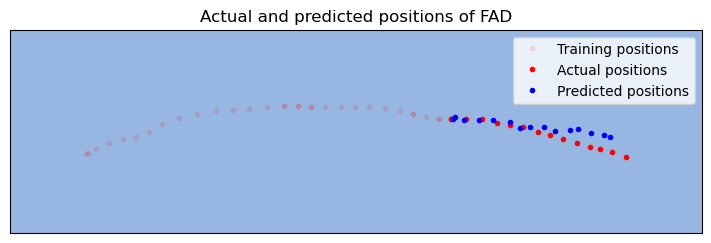

In [6]:
### MAIN PROGRAM ###
track_file = 'track_370081.geojson'
number_of_predicted = 15
number_previous_points = 12

times, positions, change_in_positions = read_data(track_file)

predicted_changes = np.zeros((number_of_predicted,2)).astype(float)

for index in range(number_of_predicted):
    
    data, data_predict, targets = prepare_data(times, change_in_positions, number_of_predicted, number_previous_points, index+1)
    
    predicted_change_in_positions = linear_regression_model(data, data_predict, targets)
    predicted_changes[index] = predicted_change_in_positions[0]
            

errors = plot_results(positions, predicted_changes, number_of_predicted)

Text(0.5, 0, 'index')

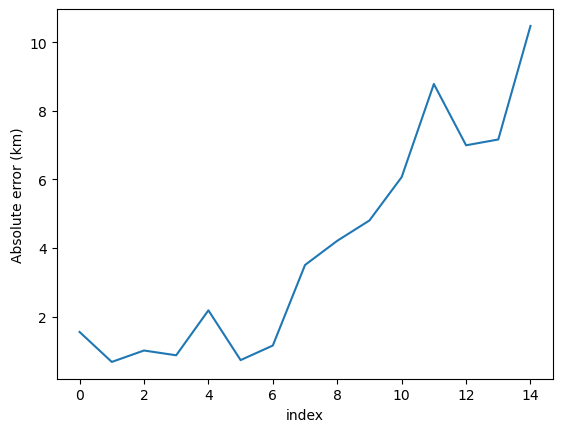

In [7]:
plt.plot(errors)
plt.ylabel('Absolute error (km)')
plt.xlabel('index')